In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models
from torchvision import transforms

import glob, gzip

import random

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

In [5]:
data_p = '../Denchik/dataСlass'

In [6]:
X, y = [], []


for i, v in enumerate(('clear', 'oil')):
    fs = glob.glob(f'{data_p}/{v}/*.npy')
    
    X += fs
    y += [i] * len(fs)
    

In [7]:
len(X) == len(y)

True

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
def read_npy_array(path):
    readBands = ["B01","B02","B03", "B04", "B05","B06","B07", "B08", "B8A","B09","B10","B11","B12"]
    with open(path, 'rb') as f:
        array = np.load(f)
    array = array.transpose((2, 1, 0))        
    array /= 10000
    
    data = dict(zip(readBands, array))

    return data

In [10]:
# https://www.sciencedirect.com/science/article/pii/S2215016121001205


lambdasGenIndex = [
    lambda x: (x['B05'] + x['B06']) / x['B07'],
    lambda x: (x['B03'] + x['B04']) / x['B02'],
    lambda x: (x['B11'] + x['B12']) / x['B08'],
    lambda x: x['B03'] / x['B02'],
    lambda x: (x['B06'] + x['B07']) / x['B05']
]

In [11]:
class MyDataSet(Dataset):
    def __init__(self, x, y, transformer=None):
        self.x = x
        self.y = y
    
        self.transformer = transformer
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        data = read_npy_array(self.x[idx])
        
        # data.update({f'oilIndex{i}': f(data) for i, f in enumerate(lambdasGenIndex)})
        x = np.stack(list(data.values()))
        x = torch.tensor(x)
        # x = torch.nan_to_num(x)

        
        if self.transformer:
            x = self.transformer(x)
        
        y = torch.tensor((self.y[idx]), dtype=torch.float32)
        return x, y

In [12]:
traintransform_train = transforms.Compose([
        transforms.RandomRotation((0, 360)),
    
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ])

In [13]:
ds_train = MyDataSet(X_train, y_train, transformer=traintransform_train)
ds_val = MyDataSet(X_val, y_val)

In [14]:
batch_size = 68

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size)

In [15]:
ds_train[0][0].size()[0]

13

In [16]:
model = models.resnet101(pretrained=1)

model.conv1 = nn.Conv2d(ds_train[0][0].size()[0], model.conv1.out_channels,
                        kernel_size=model.conv1.kernel_size, stride=model.conv1.stride, padding=model.conv1.padding
                       )

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1)
)

In [17]:
weight = torch.tensor([sum(y_train) / len(y_train)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-6)

In [18]:
from tqdm.noteb

def trainLoop(model, criterion, optimizer, 
              epochs, dl_train, dl_val,
              log=None):
    
    
    log = {} if log is None else log
    log['loss'] = {'train': [], 'val': []}
    log['bestEpoch'] = 0
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        
        for X, y in dl_train:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            
            y_predict = model(X).reshape(-1)
            
            loss = criterion(torch.sigmoid(y_predict), y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss / len(dl_train))
        
        # Val
        model.eval()
        running_loss = 0
        
        val_accs = []
        
        for X, y in dl_val:
            X, y = X.to(device), y.to(device)

            y_predict = model(X).reshape(-1)
            print(y_predictdict[:10])
            
            loss = criterion(torch.sigmoid(y_predict), y)
            
            running_loss += loss.item()
            
        log['loss']['val'].append(running_loss/len(dl_val))
        
        if not log['bestEpoch'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            log['bestEpoch'] = epoch
            torch.save(model.state_dict(), 'BestModel_v2.pt')

        if not epoch % 10:
            print(f"Epoch: {epoch} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log

In [19]:
%%time
log = {}

log = trainLoop(model, criterion, optimizer, 101, dl_train, dl_val, log)

KeyboardInterrupt: 

0


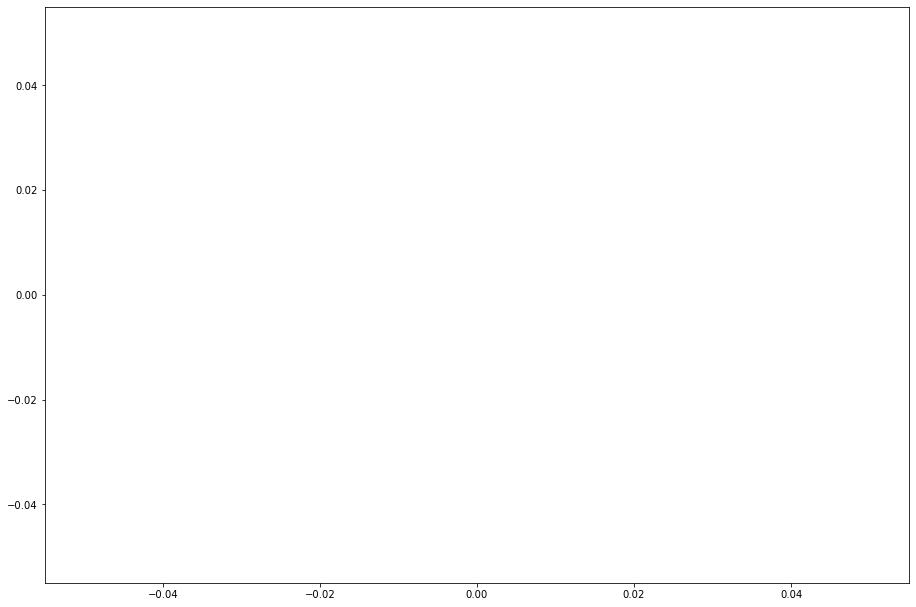

In [20]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [21]:
model = models.resnet101(pretrained=1)

model.conv1 = nn.Conv2d(ds_train[0][0].size()[0], model.conv1.out_channels,
                        kernel_size=model.conv1.kernel_size, stride=model.conv1.stride, padding=model.conv1.padding
                       )

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1)
)

model.load_state_dict(torch.load('BestModel.pt'))
model.eval()
model.to(device)
''

''

In [22]:
def print_real(X):
    X = np.concatenate([X[3], X[2], X[1]], axis=0).reshape(3, 64, 64)
    X = np.moveaxis(X, 0, -1)
    X /= 0.8 * X.max() 
    plt.imshow(X)
    

def print_val(i):
    X, y = ds_val[i]
    print_real(X)
    y_predict = model(X.to(device).reshape(-1, *X.size()))

    print(f'y: {y} || y_predict: {torch.sigmoid(y_predict).item()}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y: 1.0 || y_predict: 0.9998399019241333


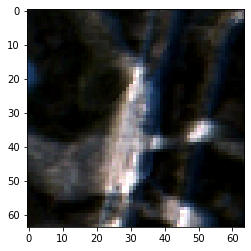

In [23]:
print_val(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y: 0.0 || y_predict: 0.003072933526709676


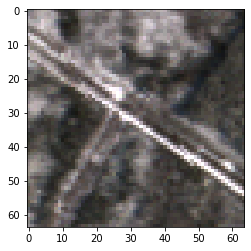

In [24]:
print_val(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y: 1.0 || y_predict: 0.9999607801437378


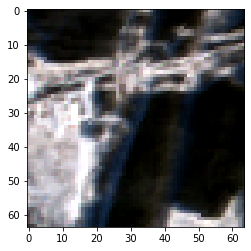

In [25]:
print_val(10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y: 1.0 || y_predict: 0.999919056892395


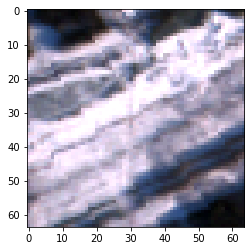

In [26]:
print_val(15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y: 1.0 || y_predict: 0.999996542930603


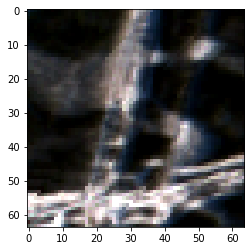

In [27]:
print_val(25)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y: 0.0 || y_predict: 0.0002612473617773503


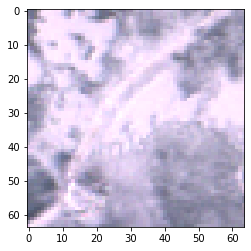

In [28]:
print_val(35)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y: 1.0 || y_predict: 0.9999271631240845


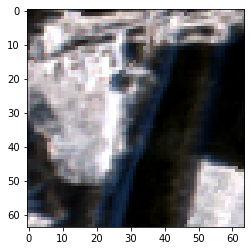

In [29]:
print_val(40)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


y: 1.0 || y_predict: 0.9999834299087524


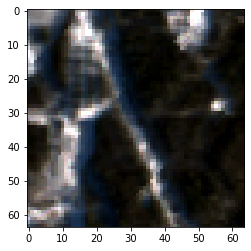

In [30]:
print_val(-1)